# Descriptive Statistics

In [19]:
from pyspark.sql.functions import size, expr, when, col, explode, array_max, udf
from pyspark.sql.types import IntegerType, ArrayType
from pyspark.ml.feature import Bucketizer
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt

import os
import sys

os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

In [2]:
spark = SparkSession.builder.appName("Forum Question Analyzer") \
    .config("spark.jars.packages", "com.databricks:spark-xml_2.12:0.17.0") \
    .getOrCreate()
posts = spark.read \
    .format("com.databricks.spark.xml") \
    .option("rootTag", "posts") \
    .option("rowTag", "row") \
    .load("tex.stackexchange.com/Posts.xml") \
    .alias('posts')
users = spark.read \
    .format("com.databricks.spark.xml") \
    .option("rootTag", "users") \
    .option("rowTag", "row") \
    .load("tex.stackexchange.com/Users.xml") \
    .alias('users')
tags = spark.read \
    .format("com.databricks.spark.xml") \
    .option("rootTag", "tags") \
    .option("rowTag", "row") \
    .load("tex.stackexchange.com/Tags.xml") \
    .alias('tags')

In [3]:
questions = posts.filter(posts._PostTypeId == 1)
answers = posts.filter(posts._PostTypeId == 2)

In [4]:
print("Posts count: ", posts.count())
print("Questions: ", questions.count())
print("Answers: ", answers.count())
acc = questions.filter(questions._AcceptedAnswerId.isNotNull()).count()
print(f"Accepted answers: {acc} ({acc / questions.count()*100:.2f}% of questions and {acc / answers.count()*100:.2f}% of answers)")

Posts count:  584821
Questions:  255804
Answers:  326115
Accepted answers: 153808 (60.13% of questions and 47.16% of answers)


## Tags

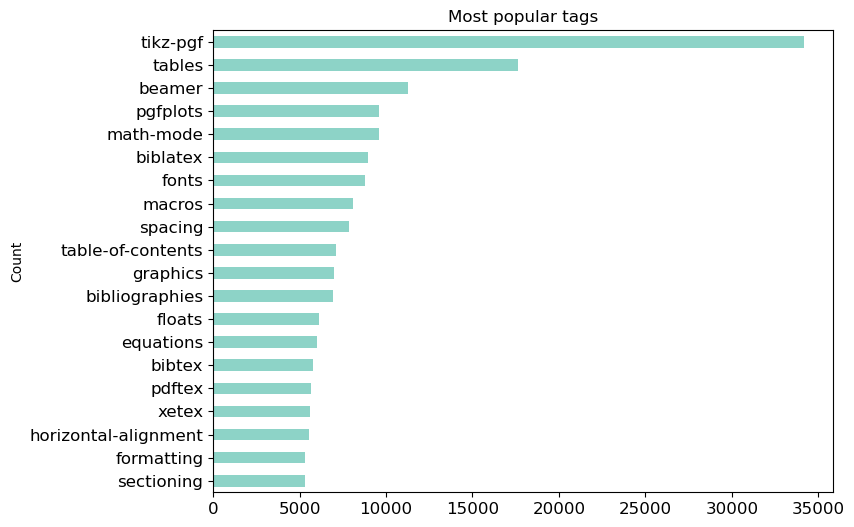

In [5]:
# Most popular tags
tags.select("_TagName", "_Count").orderBy("_Count", ascending=False).limit(20).toPandas()[::-1] \
    .plot.barh(x="_TagName", y="_Count", title="Most popular tags",
              figsize=(8, 6), rot=0, legend=False, fontsize=12,
              colormap='Set3', xlabel="Count", ylabel="Tag")
plt.show()

In [6]:
# Probability of a question having an accepted answer based on tag
questions = questions.withColumn("tags", expr("split(substring(_Tags, 2, length(_Tags) - 2), '><')"))
questions = questions.withColumn("accepted", when(col("_AcceptedAnswerId").isNull(), 0).otherwise(1))

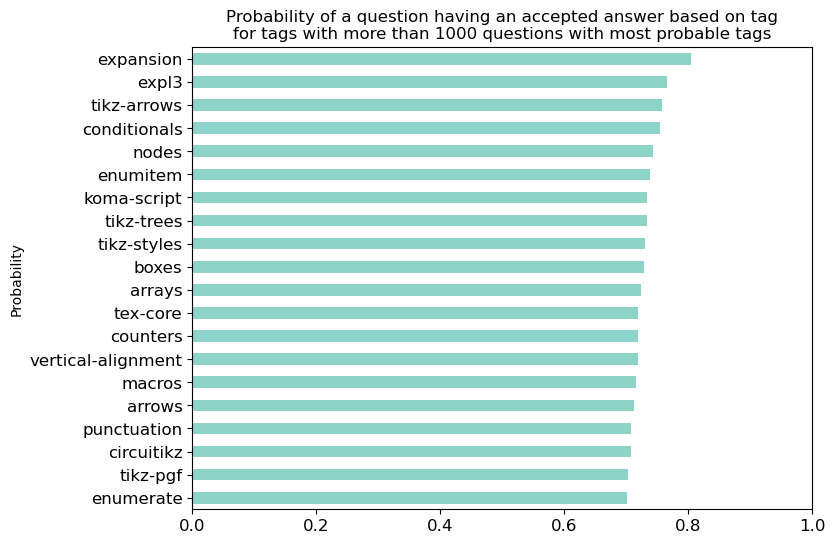

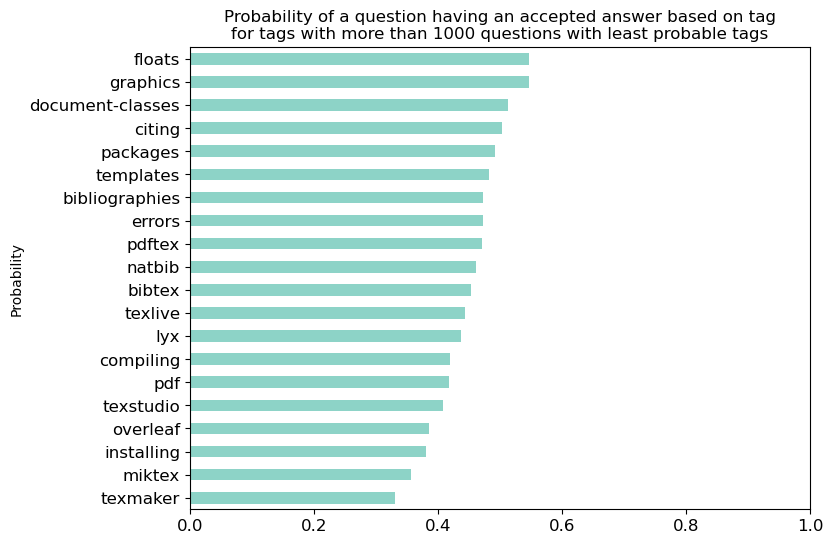

In [7]:
questions_exploded = questions.select("*", explode(questions.tags).alias("tag"))
prob = questions_exploded.groupBy("tag").agg({"accepted": "avg"}).where("count(tag) > 1000")
prob.orderBy("avg(accepted)", ascending=False).limit(20).toPandas()[::-1] \
    .plot.barh(x="tag", y="avg(accepted)",
               title="Probability of a question having an accepted answer based on tag\n"
                     "for tags with more than 1000 questions with most probable tags", 
               figsize=(8, 6), rot=0, legend=False, fontsize=12, colormap='Set3',
               xlabel="Probability", ylabel="Tag", xlim=(0, 1))
prob.orderBy("avg(accepted)").limit(20).toPandas() \
    .plot.barh(x="tag", y="avg(accepted)",
               title="Probability of a question having an accepted answer based on tag\n"
                     "for tags with more than 1000 questions with least probable tags", 
               figsize=(8, 6), rot=0, legend=False, fontsize=12, colormap='Set3',
               xlabel="Probability", ylabel="Tag", xlim=(0, 1))
plt.show()

In [8]:
#UDF - Fast way to change tag names to tag counts from Tags table

tag_counts = tags.select("_TagName", "_Count").rdd.collectAsMap()

def replace_tags_with_counts(tags):
    return [tag_counts.get(tag, 0) for tag in tags]

replace_tags_with_counts_udf = udf(replace_tags_with_counts, ArrayType(IntegerType()))

posts = posts.filter(posts._PostTypeId==1)
questions = posts.withColumn("_Tags", expr("split(substring(_Tags, 2, length(_Tags) - 2), '><')"))\
            .withColumn("_Body", size(expr("split(_Body, ' ')")))\
            .withColumn("_Title", size(expr("split(_Title, ' ')")))

data = questions.join(users, questions._OwnerUserId == users._Id).select(
    questions._Id.alias("QuestionId"),
    questions._Body.alias("BodyLength"),
    questions._Title.alias("TitleLength"),
    array_max(replace_tags_with_counts_udf(questions._Tags)).alias("TagsCountMax"),
    size(questions._Tags).alias("NumberOfTags"),
    users._Id.alias("OwnerId"),
    users._DownVotes.alias("OwnerDownVotes"),
    users._UpVotes.alias("OwnerUpVotes"),
    users._Reputation.alias("OwnerReputation"),
    users._Views.alias("OwnerViews"),
    (questions._CreationDate - users._CreationDate).cast("integer").alias("UserExperience"),
    when(col("_AcceptedAnswerId").isNull(), 0).otherwise(1).alias("Accepted")
)

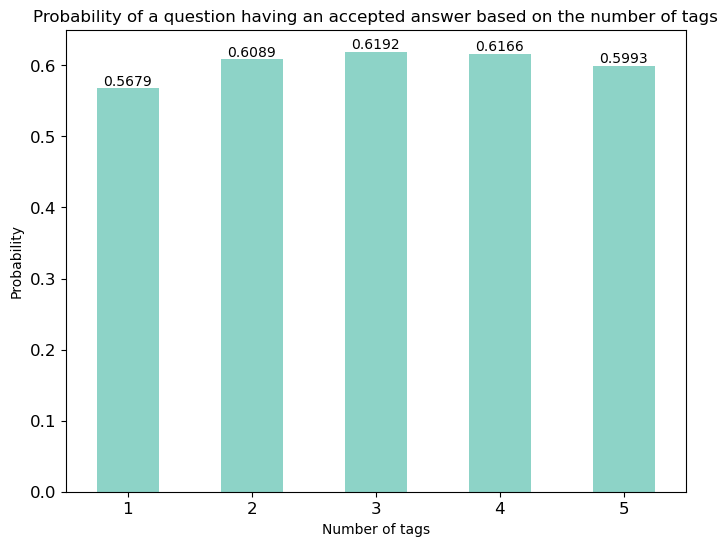

In [9]:
# Probability of a question having an accepted answer based on the tag number
ax = data.groupBy("NumberOfTags").agg({"Accepted": "avg"}).orderBy("NumberOfTags").toPandas() \
         .plot.bar(x="NumberOfTags", y="avg(Accepted)",
                   title="Probability of a question having an accepted answer based on the number of tags", 
                   figsize=(8, 6), rot=0, legend=False, fontsize=12, colormap='Set3',
                   xlabel="Number of tags", ylabel="Probability")
ax.bar_label(ax.containers[0], fmt='%.4f')
plt.show()

## Question details

In [10]:
# Histogram of acceptance rate based on question creation date
questions = questions.withColumn("creation_date", expr("date_format(_CreationDate, 'yyyy')")) \
    .withColumn("Accepted", when(col("_AcceptedAnswerId").isNull(), 0).otherwise(1))

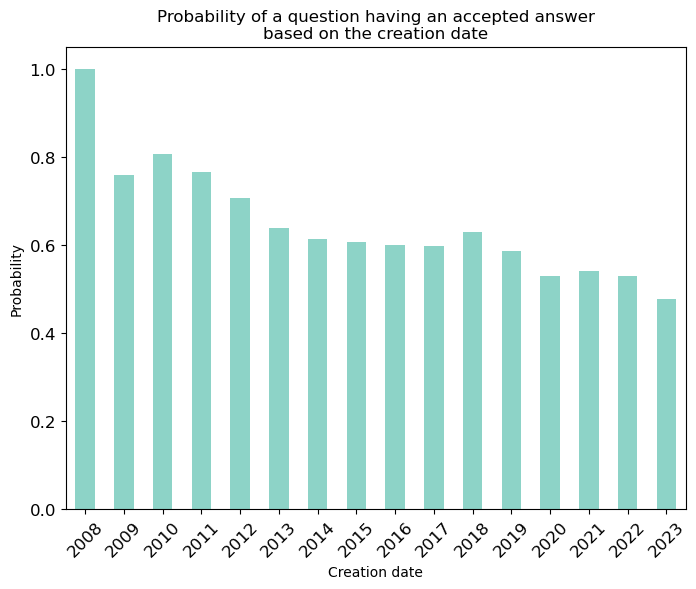

In [11]:
# Histogram of acceptance rate based on question creation date
ax = questions.groupBy("creation_date").agg({"Accepted": "avg"}).orderBy("creation_date").toPandas() \
         .plot.bar(x="creation_date", y="avg(Accepted)",
                   title="Probability of a question having an accepted answer\n"
                         "based on the creation date", 
                   figsize=(8, 6), rot=45, legend=False, fontsize=12, colormap='Set3',
                   xlabel="Creation date", ylabel="Probability")
plt.show()

## User details

In [12]:
# Probability of a question having an accepted answer based on the user reputation
questions = questions.join(users.select("_Id", "_Reputation"), col("posts._OwnerUserId") == col("users._Id")).drop("_Id")

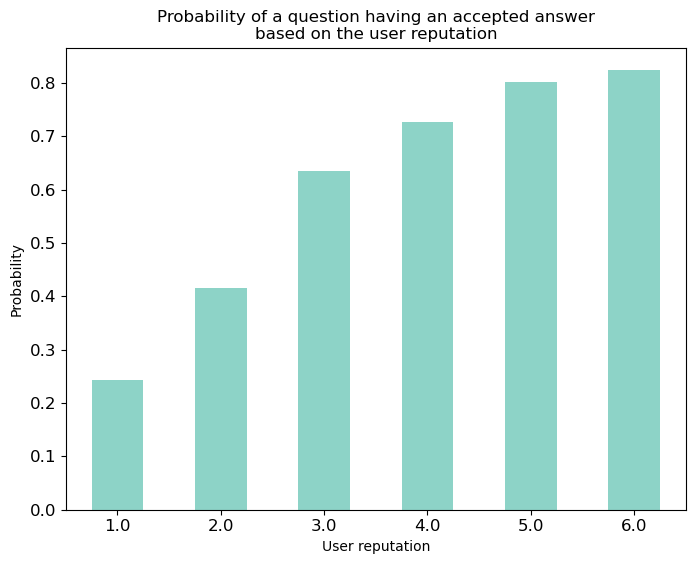

In [13]:
bucketizer = Bucketizer(splits=[float("-inf"), 0, 10, 100, 1000, 10000, 100000, float("inf")], inputCol="_Reputation", outputCol="reputation_bucket")
questions_bucketed = bucketizer.transform(questions)
questions_bucketed.groupBy("reputation_bucket").agg({"accepted": "avg"}).orderBy("reputation_bucket").toPandas() \
         .plot.bar(x="reputation_bucket", y="avg(accepted)",
                   title="Probability of a question having an accepted answer\n"
                         "based on the user reputation", 
                   figsize=(8, 6), rot=0, legend=False, fontsize=12, colormap='Set3',
                   xlabel="User reputation", ylabel="Probability")
plt.show()

In [14]:
# Probability of a question having an accepted answer based on the user membership duration
questions = questions.join(users.select("_Id", "_CreationDate"), col("posts._OwnerUserId") == col("users._Id")).drop("_Id") \
    .withColumn("membership_duration", expr("(posts._CreationDate - users._CreationDate)/31536000").cast('integer'))

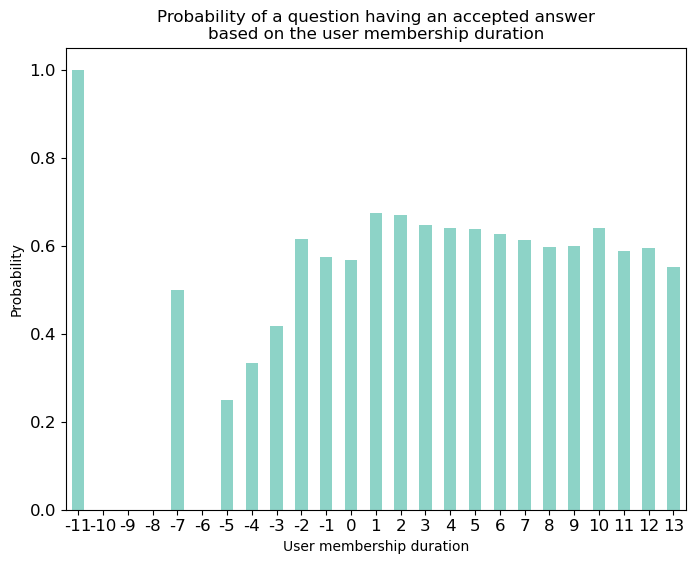

In [15]:
questions.groupBy("membership_duration").agg({"accepted": "avg"}).orderBy("membership_duration").toPandas() \
         .plot.bar(x="membership_duration", y="avg(accepted)",
                   title="Probability of a question having an accepted answer\n"
                         "based on the user membership duration", 
                   figsize=(8, 6), rot=0, legend=False, fontsize=12, colormap='Set3',
                   xlabel="User membership duration", ylabel="Probability")
plt.show()